# Logistic Regression

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.display import HTML

HTML("""
<style>
 {
    display: table-cell;
    text-align: center;
   .output_png vertical-align: middle;
}
</style>
""")
import pandas as pd
import numpy as np
df = pd.read_csv('https://spark-public.s3.amazonaws.com/dataanalysis/loansData.csv')


# Remove % sign from DtI Ratio and interest rate
df['Debt.To.Income.Ratio'] = df['Debt.To.Income.Ratio'].apply(lambda x: x[:-1]).astype('float64')
df['Interest.Rate'] = df['Interest.Rate'].apply(lambda x: x[:-1]).astype('float64')

#Bucket categorical variables as float. Float type will allow easy removal of outliers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.State = le.fit_transform(df.State).astype('float64')
df['Home.Ownership'] = le.fit_transform(df['Home.Ownership']).astype('float64')


#extract float val from string
def numonly(string):
    res = ''
    for x in string:
        if x.isdigit():
            res = res+x
    return int(res)
df.loc[:,'Loan.Length'] = df['Loan.Length'].apply(numonly).astype('float64')

#average te FICO Range/ convert to float
def noline(string):
    x = string.split('-')
    c = 0
    for y in x:
        y=int(y)
        c+=y
    return c/2
df.loc[:,'FICO.Range'] = df['FICO.Range'].apply(noline).astype('float64')


#delete superfluous features
del df['Loan.Purpose']
del df['Employment.Length']


#drop NaN values and remove outliers
df = df.dropna()
from scipy import stats
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

In [2]:
df.head()

,Amount.Requested,Amount.Funded.By.Investors,Interest.Rate,Loan.Length,Debt.To.Income.Ratio,State,Home.Ownership,Monthly.Income,FICO.Range,Open.CREDIT.Lines,Revolving.CREDIT.Balance,Inquiries.in.the.Last.6.Months
81174,20000,20000.0,8.90,36.0,14.90,36.0,0.0,6541.67,737.0,14.0,14272.0,2.0
99592,19200,19200.0,12.12,36.0,28.36,38.0,0.0,4583.33,717.0,12.0,11140.0,1.0
80059,35000,35000.0,21.98,60.0,23.81,4.0,0.0,11500.00,692.0,14.0,21977.0,1.0
15825,10000,9975.0,9.99,36.0,14.30,15.0,0.0,3833.33,697.0,10.0,9346.0,0.0
33182,12000,12000.0,11.71,36.0,18.78,27.0,4.0,3195.00,697.0,11.0,14469.0,0.0


### Derive the probablility that the interest rate is less than 14%

In [3]:
imp = df.loc[:,['Interest.Rate', 'FICO.Range', 'Loan.Length', 'Monthly.Income', 'Amount.Requested']]
imp["Claff"] =imp['Interest.Rate']<=14
imp.head()

,Interest.Rate,FICO.Range,Loan.Length,Monthly.Income,Amount.Requested,Claff
81174,8.90,737.0,36.0,6541.67,20000,True
99592,12.12,717.0,36.0,4583.33,19200,True
80059,21.98,692.0,60.0,11500.00,35000,False
15825,9.99,697.0,36.0,3833.33,10000,True
33182,11.71,697.0,36.0,3195.00,12000,True


## Stats Models API
works like scikit learn but provides more information.

has a useful .predict(X) and .summary() method

### Quick Scatter

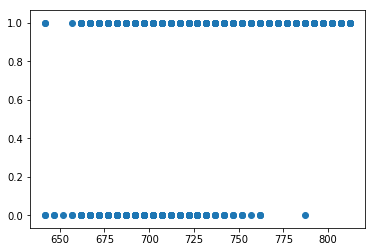

In [4]:
plt.scatter(imp['FICO.Range'], imp['Claff'])

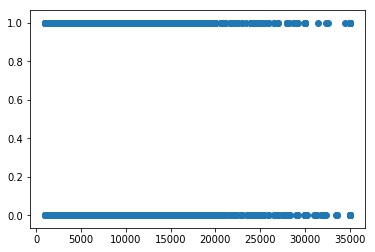

In [5]:
plt.scatter(imp['Amount.Requested'], imp['Claff'])

## The Model

In [6]:
import statsmodels.api as sm
imp['intercept']=1
ind_cols = ['FICO.Range','Amount.Requested', 'intercept']
logit = sm.Logit(imp['Claff'], imp[ind_cols])
results = logit.fit()

C:\Users\Harrison\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Optimization terminated successfully.
         Current function value: 0.373146
         Iterations 8


In [7]:
results.params

FICO.Range           0.085017
Amount.Requested    -0.000168
intercept          -56.944965
dtype: float64

### $z = -56.944 + 0.0850*FicoScore -0.000168*LoanAmount$


Probability that loan has an interest rate less than 14%

# $p(z) = \frac{1}{1 + e^{-56.945 + 0.085*FicoScore + -0.000168*LoanAmount}}$

In [8]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Claff   No. Observations:                 2376
Model:                          Logit   Df Residuals:                     2373
Method:                           MLE   Df Model:                            2
Date:                Sun, 25 Mar 2018   Pseudo R-squ.:                  0.4489
Time:                        20:11:42   Log-Likelihood:                -886.59
converged:                       True   LL-Null:                       -1608.9
                                        LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
FICO.Range           0.0850      0.004     23.076      0.000       0.078       0.092
Amount.Requested    -0.0002   1.02e-05    -16.507      0.000      -0.000      -0.000
intercept          -56.9450      2.486    -22.907      0.000     -61.817     -52.073
====================================================================================
"""

## SciKit Learn

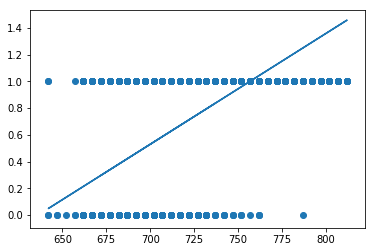

In [9]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(imp['FICO.Range'].values.reshape(-1,1), imp.Claff)
y_pred = linreg.predict(imp['FICO.Range'].values.reshape(-1,1))
plt.plot(imp['FICO.Range'], y_pred)
plt.scatter(imp['FICO.Range'], imp['Claff'])

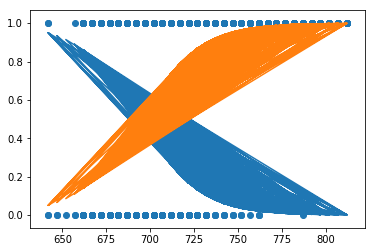

In [10]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
log = LogisticRegressionCV()
log.fit(imp['FICO.Range'].values.reshape(-1,1), imp.Claff)
y_pred = log.predict_proba(imp['FICO.Range'].values.reshape(-1,1))
plt.plot(imp['FICO.Range'], y_pred)
plt.scatter(imp['FICO.Range'], imp['Claff'])

# Iris Dataset

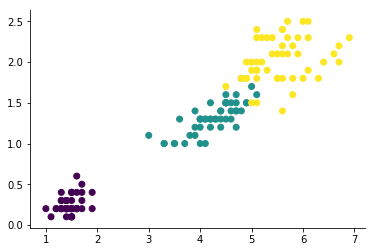

In [11]:
from sklearn.datasets import load_iris
import seaborn as sns

iris = load_iris()
X = iris.data[:,2:4]
y = iris.target
plt.scatter(X[:,0],X[:,1], c = y[:])
sns.despine()

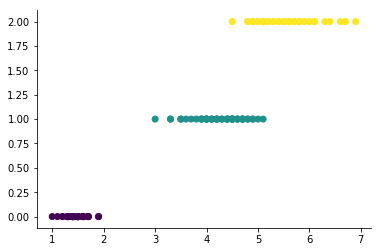

In [12]:
plt.scatter(X[:,0], y[:], c= y[:])
sns.despine()

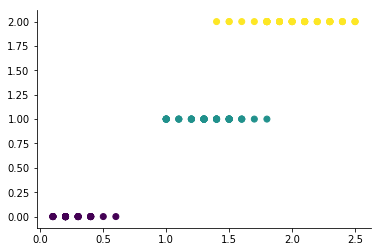

In [13]:
plt.scatter(X[:,1], y[:], c= y[:])
sns.despine()

Here we standardize our data and split our data

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
scale.fit(X_train)
X_train_std = scale.transform(X_train)
X_test_std = scale.transform(X_test)



### The Logistic Model

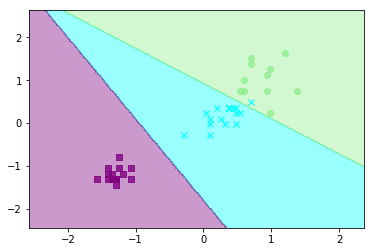

In [21]:
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression(C = 10000, random_state = 0)
logr.fit(X_train_std, y_train)
import VisualFuncs as vf


vf.VDR(X_test_std, y_test, classifier = logr)

### Predicting Class Probabilities

In [26]:
logr.predict_proba(X_test_std[0,:].reshape(1,-1))

array([[  1.32305547e-14,   6.29676452e-02,   9.37032355e-01]])

In [39]:
predict = logr.predict_proba(X)
predict

array([[  8.92125320e-13,   4.74463326e-01,   5.25536674e-01],
       [  8.92125320e-13,   4.74463326e-01,   5.25536674e-01],
       [  2.31701463e-12,   4.68445742e-01,   5.31554258e-01],
       [  3.44893046e-13,   4.79706030e-01,   5.20293970e-01],
       [  8.92125320e-13,   4.74463326e-01,   5.25536674e-01],
       [  9.38777397e-15,   4.80251767e-01,   5.19748233e-01],
       [  3.81072980e-13,   4.67682394e-01,   5.32317606e-01],
       [  3.44893046e-13,   4.79706030e-01,   5.20293970e-01],
       [  8.92125320e-13,   4.74463326e-01,   5.25536674e-01],
       [  8.10680418e-13,   4.84082618e-01,   5.15917382e-01],
       [  3.44893046e-13,   4.79706030e-01,   5.20293970e-01],
       [  1.33695751e-13,   4.84024644e-01,   5.15975356e-01],
       [  2.09435972e-12,   4.80302791e-01,   5.19697209e-01],
       [  3.81811057e-11,   4.79675324e-01,   5.20324676e-01],
       [  6.05980411e-12,   4.62443366e-01,   5.37556634e-01],
       [  6.28245021e-14,   4.68020964e-01,   5.3197903